# Studying the impact of hard samples

In this notebook we explore the impact of including hard samples in the training data. 

`**Disclaimer** this notebook is a summary of multiple experiments created to present the explorative process. We omited data loading and preprocessing, etc. For full, functioning notebooks see the 'examples' included.`

### Training 1 

In [ ]:
print(f"Number of easy samples {len(df[df_ih['resnet_small'] <= 0.05])}")

Number of easy samples 1388715


In [ ]:
# Prepare undersampled data

df_train = pd.concat([
    df[(df['label'] == 0) & (df_ih['resnet_small'] <= 0.05)].sample(n=300000, random_state=3617),
    df[df['label'] == 1].sample(frac=1., replace=False)
    ], axis=0).sample(frac=1)[['miRNA', 'gene', 'label']]
df_train.reset_index(inplace=True)
del df_train['index']

print(f"Using {df_train.shape[0]} training samples.")

Using 315392 training samples.


In [ ]:
tqdm.pandas(desc='Encoding training data')
train_data_easy = df_train[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

Encoding training data:   0%|          | 0/315392 [00:00<?, ?it/s]

In [ ]:
with strategy.scope():

  resnet_easy = create_res_net(name="resnet_easy")
  resnet_easy.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

resnet_easy.summary()

Model: "resnet_easy"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_60 (BatchN  (None, 50, 20, 1)   4           ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_62 (Conv2D)             (None, 50, 20, 16)   160         ['batch_normalization_60[0][0]'] 
                                                                                                  
 re_lu_58 (ReLU)                (None, 50, 20, 16)   0           ['conv2d_62[0][0]']    

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=60, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = resnet_easy.fit(
    x=np.array(list(train_data_easy[0])), 
    y=np.array(list(train_data_easy[1])),

    shuffle=True,
    batch_size=128*8,

    validation_split=0.05,
    verbose=1,
    epochs=180,
    callbacks=callbacks
    )

Epoch 1/180
293/293 [==============================] - 54s 99ms/step - loss: 0.2398 - precision: 0.1577 - recall: 0.1840 - val_loss: 0.2297 - val_precision: 1.0000 - val_recall: 0.0219
Epoch 2/180
293/293 [==============================] - 13s 45ms/step - loss: 0.1100 - precision: 0.7520 - recall: 0.4544 - val_loss: 0.1602 - val_precision: 0.9948 - val_recall: 0.2613
Epoch 3/180
293/293 [==============================] - 13s 46ms/step - loss: 0.1051 - precision: 0.7723 - recall: 0.5345 - val_loss: 0.0705 - val_precision: 0.8705 - val_recall: 0.6895
Epoch 4/180
293/293 [==============================] - 13s 43ms/step - loss: 0.0816 - precision: 0.8540 - recall: 0.6398 - val_loss: 0.0829 - val_precision: 0.9376 - val_recall: 0.6785
Epoch 5/180
293/293 [==============================] - 13s 43ms/step - loss: 0.0730 - precision: 0.8813 - recall: 0.6690 - val_loss: 0.0971 - val_precision: 0.7624 - val_recall: 0.6539
Epoch 6/180
293/293 [==============================] - 13s 46ms/step - loss

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


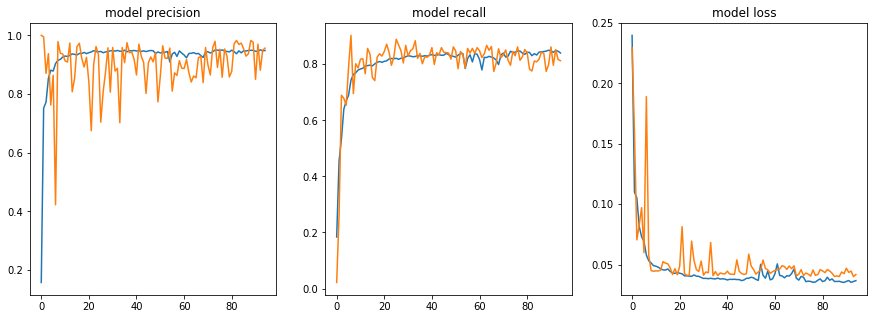

In [ ]:
plot_training(history)

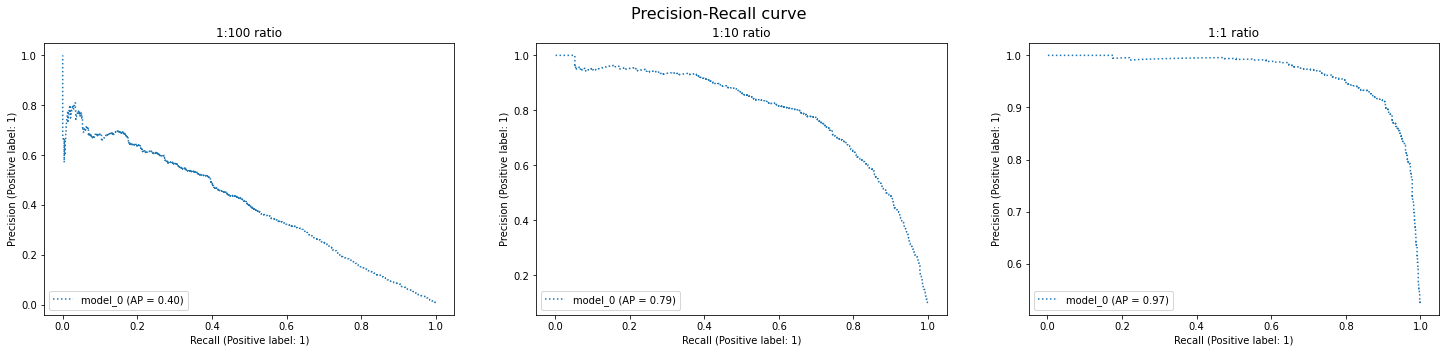

In [ ]:
test_and_plot([resnet_easy], test_data_1, test_data_10, test_data_100)

### Training 2

Use easy samples in combination with the hardest ones.

In [ ]:
# print(f"Number of easy samples {len(df[df_ih['resnet_small'] <= 0.05])}")
print(f"Number of easy samples {len(df[(df_ih['resnet_small'] > 0.5)])}")

Number of easy samples 21816


In [ ]:
# Prepare undersampled data

num_hard_instances = len(df[(df_ih['resnet_small'] > 0.5)])

df_train = pd.concat([
    df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.5)],
    df[(df['label'] == 0) & (df_ih['resnet_small'] <= 0.05)].sample(n=300000-num_hard_instances, random_state=3617),
    df[df['label'] == 1].sample(frac=1., replace=False)
    ], axis=0).sample(frac=1)[['miRNA', 'gene', 'label']]
df_train.reset_index(inplace=True)
del df_train['index']

print(f"Using {df_train.shape[0]} training samples.")

Using 310934 training samples.


In [ ]:
tqdm.pandas(desc='Encoding training data')
train_data_2 = df_train[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

Encoding training data:   0%|          | 0/310934 [00:00<?, ?it/s]

In [ ]:
with strategy.scope():

  resnet_2 = create_res_net(name="resnet_2")
  resnet_2.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

resnet_2.summary()

Model: "resnet_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_90 (BatchN  (None, 50, 20, 1)   4           ['input_4[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_93 (Conv2D)             (None, 50, 20, 16)   160         ['batch_normalization_90[0][0]'] 
                                                                                                  
 re_lu_87 (ReLU)                (None, 50, 20, 16)   0           ['conv2d_93[0][0]']       

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=60, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = resnet_2.fit(
    x=np.array(list(train_data_2[0])), 
    y=np.array(list(train_data_2[1])),

    shuffle=True,
    batch_size=128*8,

    validation_split=0.05,
    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

Epoch 1/1000
289/289 [==============================] - 55s 106ms/step - loss: 0.2631 - precision: 0.0502 - recall: 0.0376 - val_loss: 0.6920 - val_precision: 0.0270 - val_recall: 0.1890
Epoch 2/1000
289/289 [==============================] - 13s 45ms/step - loss: 0.1640 - precision: 0.3968 - recall: 0.0774 - val_loss: 0.3496 - val_precision: 0.2450 - val_recall: 0.6640
Epoch 3/1000
289/289 [==============================] - 13s 45ms/step - loss: 0.1449 - precision: 0.5029 - recall: 0.1618 - val_loss: 0.1679 - val_precision: 0.4054 - val_recall: 0.5709
Epoch 4/1000
289/289 [==============================] - 13s 45ms/step - loss: 0.1341 - precision: 0.5592 - recall: 0.2103 - val_loss: 0.1335 - val_precision: 0.5700 - val_recall: 0.2992
Epoch 5/1000
289/289 [==============================] - 12s 42ms/step - loss: 0.1319 - precision: 0.5432 - recall: 0.2253 - val_loss: 0.1374 - val_precision: 0.4853 - val_recall: 0.3898
Epoch 6/1000
289/289 [==============================] - 13s 45ms/step

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


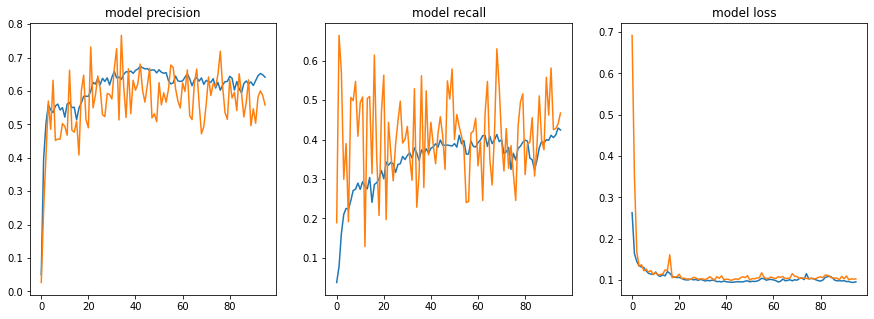

In [ ]:
plot_training(history)

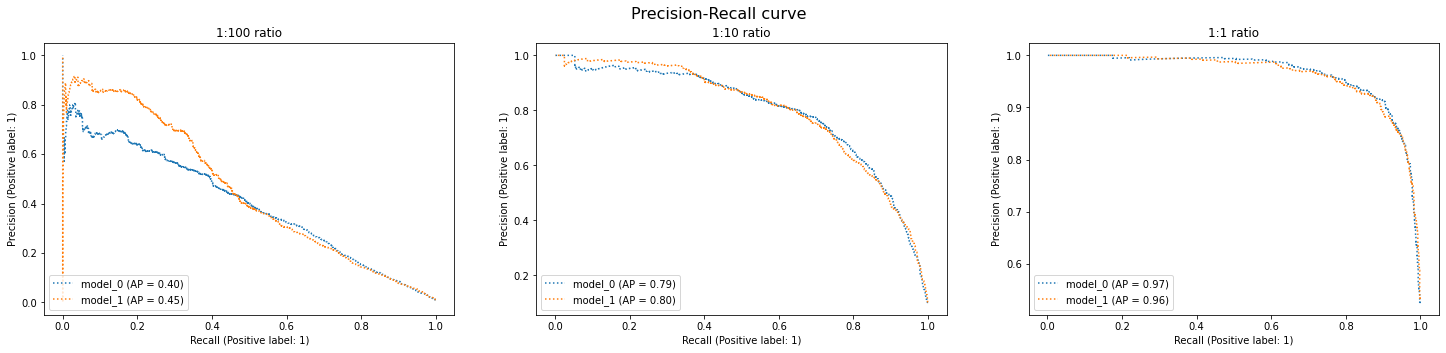

In [ ]:
test_and_plot([resnet_easy, resnet_2], test_data_1, test_data_10, test_data_100)

In [ ]:
resnet_easy.save(f"{dir_path}/models/different_ratios_of_hard_instances/resnet_easy.h5")
resnet_2.save(f"{dir_path}/models/different_ratios_of_hard_instances/resnet_2.h5")

### Training 3

Discard "super easy" and "super hard" samples.

In [ ]:
# print(f"Number of easy samples {len(df[df_ih['resnet_small'] <= 0.05])}")
print(f"Number of easy samples {len(df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.01)])}")
print(f"Number of easy samples {len(df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.01) & (df_ih['resnet_small'] < 0.9)])}")

Number of easy samples 400542
Number of easy samples 398648


In [ ]:
# Prepare undersampled data

df_train = pd.concat([
    df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.01) & (df_ih['resnet_small'] < 0.9)].sample(n=300000, random_state=3617),
    df[df['label'] == 1].sample(frac=1., replace=False)
    ], axis=0).sample(frac=1)[['miRNA', 'gene', 'label']]
df_train.reset_index(inplace=True)
del df_train['index']

print(f"Using {df_train.shape[0]} training samples.")

Using 315392 training samples.


In [ ]:
tqdm.pandas(desc='Encoding training data')
train_data_3 = df_train[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

Encoding training data:   0%|          | 0/315392 [00:00<?, ?it/s]

In [ ]:
with strategy.scope():

  resnet_3 = create_res_net(name="resnet_3")
  resnet_3.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

resnet_3.summary()

Model: "resnet_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_120 (Batch  (None, 50, 20, 1)   4           ['input_5[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 conv2d_124 (Conv2D)            (None, 50, 20, 16)   160         ['batch_normalization_120[0][0]']
                                                                                                  
 re_lu_116 (ReLU)               (None, 50, 20, 16)   0           ['conv2d_124[0][0]']      

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=60, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = resnet_3.fit(
    x=np.array(list(train_data_3[0])), 
    y=np.array(list(train_data_3[1])),

    shuffle=True,
    batch_size=128*8,

    validation_split=0.05,
    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

Epoch 1/1000
293/293 [==============================] - 53s 100ms/step - loss: 0.2457 - precision: 0.0564 - recall: 0.0336 - val_loss: 0.3099 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
293/293 [==============================] - 13s 45ms/step - loss: 0.1637 - precision: 0.5544 - recall: 0.0818 - val_loss: 0.1538 - val_precision: 0.6385 - val_recall: 0.1794
Epoch 3/1000
293/293 [==============================] - 13s 45ms/step - loss: 0.1510 - precision: 0.6117 - recall: 0.1800 - val_loss: 0.1365 - val_precision: 0.6559 - val_recall: 0.2691
Epoch 4/1000
293/293 [==============================] - 12s 42ms/step - loss: 0.1471 - precision: 0.6284 - recall: 0.2114 - val_loss: 0.1541 - val_precision: 0.4745 - val_recall: 0.4670
Epoch 5/1000
293/293 [==============================] - 13s 43ms/step - loss: 0.1422 - precision: 0.6569 - recall: 0.2364 - val_loss: 0.1400 - val_precision: 0.5474 - val_recall: 0.4037
Epoch 6/1000
293/293 [==============================] - 13s 4

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


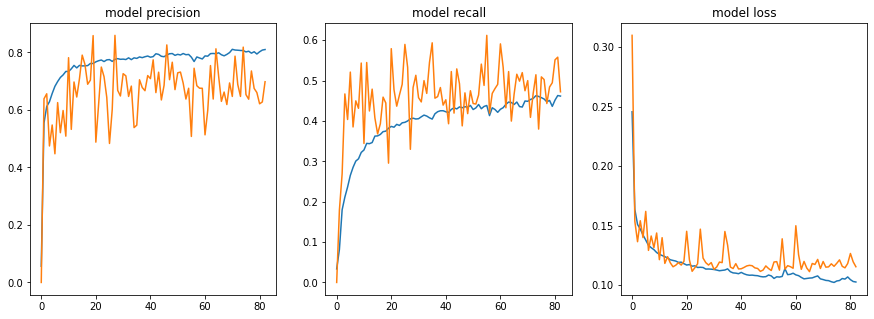

In [ ]:
plot_training(history)

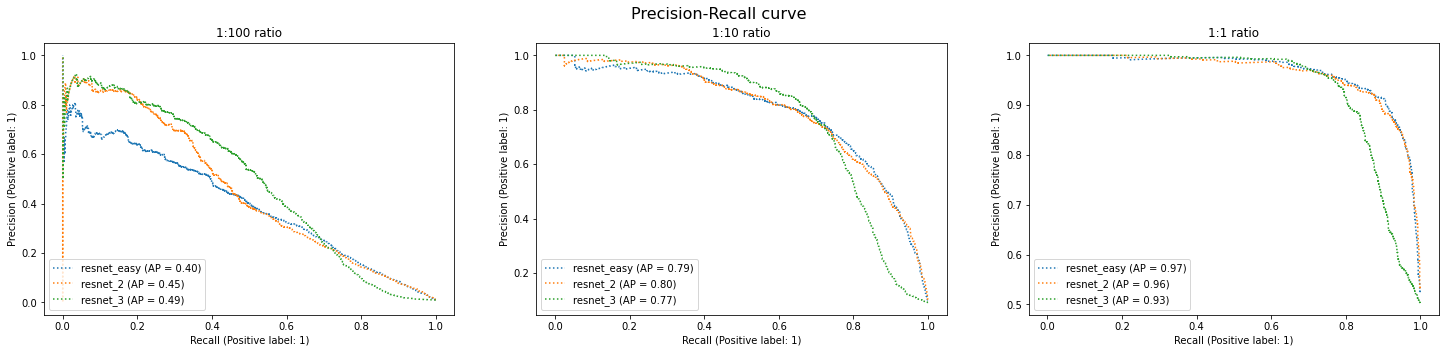

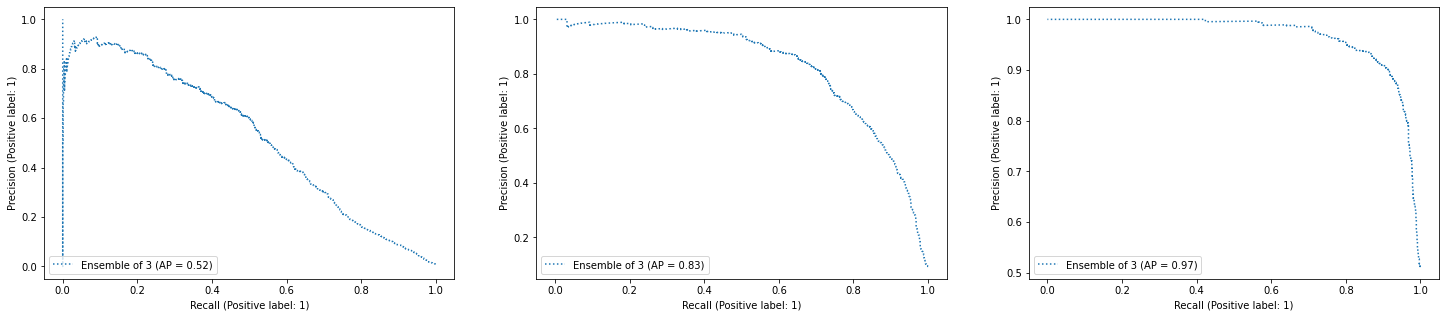

In [ ]:
test_and_plot([resnet_easy, resnet_2, resnet_3], test_data_1, test_data_10, test_data_100, combine_method='mean')

### Training 4

Combine randomly selected samples with all hard instances (not the hardest ones though).

In [ ]:
# print(f"Number of easy samples {len(df[df_ih['resnet_small'] <= 0.05])}")
print(f"Number of easy samples {len(df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.5)])}")
print(f"Number of easy samples {len(df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.0) & (df_ih['resnet_small'] < 0.9)])}")

Number of easy samples 17358
Number of easy samples 1537306


In [ ]:
# Prepare undersampled data

num_hard_instances = len(df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.5)])

df_train = pd.concat([
    df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.5) & (df_ih['resnet_small'] < 0.9)].sample(frac=1),
    df[(df['label'] == 0) & (df_ih['resnet_small'] < 0.9)].sample(n=300000-num_hard_instances, random_state=3617),
    
    df[df['label'] == 1].sample(frac=1., replace=False)

    ], axis=0).sample(frac=1)[['miRNA', 'gene', 'label']]
df_train.reset_index(inplace=True)
del df_train['index']

print(f"Using {df_train.shape[0]} training samples.")

Using 313498 training samples.


In [ ]:
tqdm.pandas(desc='Encoding training data')
train_data_4 = df_train[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

Encoding training data:   0%|          | 0/313498 [00:00<?, ?it/s]

In [ ]:
with strategy.scope():

  resnet_4 = create_res_net(name="resnet_4")
  resnet_4.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-3, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

resnet_4.summary()

Model: "resnet_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization_150 (Batch  (None, 50, 20, 1)   4           ['input_6[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 conv2d_155 (Conv2D)            (None, 50, 20, 16)   160         ['batch_normalization_150[0][0]']
                                                                                                  
 re_lu_145 (ReLU)               (None, 50, 20, 16)   0           ['conv2d_155[0][0]']      

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=60, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = resnet_4.fit(
    x=np.array(list(train_data_4[0])), 
    y=np.array(list(train_data_4[1])),

    shuffle=True,
    batch_size=128*8,

    validation_split=0.05,
    verbose=1,
    epochs=1000,
    callbacks=callbacks
    )

Epoch 1/1000
291/291 [==============================] - 54s 103ms/step - loss: 0.2157 - precision: 0.1206 - recall: 0.0603 - val_loss: 0.3879 - val_precision: 0.1128 - val_recall: 0.1468
Epoch 2/1000
291/291 [==============================] - 13s 45ms/step - loss: 0.1559 - precision: 0.4586 - recall: 0.1414 - val_loss: 0.3431 - val_precision: 0.2520 - val_recall: 0.6971
Epoch 3/1000
291/291 [==============================] - 13s 45ms/step - loss: 0.1465 - precision: 0.5169 - recall: 0.1910 - val_loss: 0.1419 - val_precision: 0.5452 - val_recall: 0.3029
Epoch 4/1000
291/291 [==============================] - 13s 45ms/step - loss: 0.1327 - precision: 0.5962 - recall: 0.2077 - val_loss: 0.1265 - val_precision: 0.8077 - val_recall: 0.0556
Epoch 5/1000
291/291 [==============================] - 12s 43ms/step - loss: 0.1379 - precision: 0.5622 - recall: 0.2206 - val_loss: 0.2176 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/1000
291/291 [==============================] - 13s 4

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


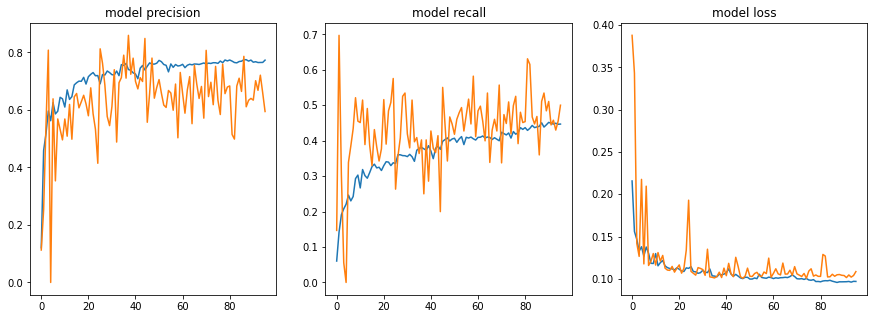

In [ ]:
plot_training(history)

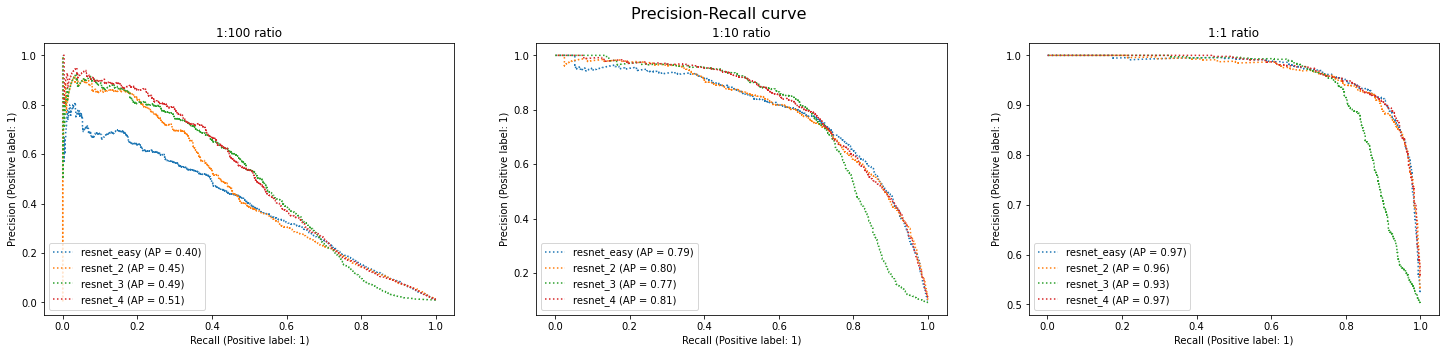

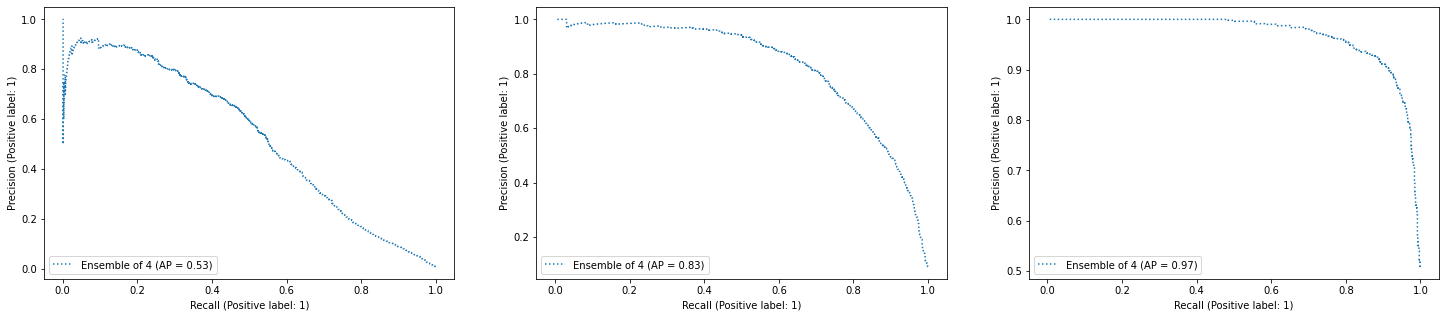

In [ ]:
test_and_plot([resnet_easy, resnet_2, resnet_3, resnet_4], test_data_1, test_data_10, test_data_100, combine_method='mean')

### Training 5

Retrain ResNet small on hard negative instances + positive samples.

In [ ]:
print(f"Number of hard samples {len(df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.5)])}")

Number of hard samples 17358


In [ ]:
# Prepare undersampled data

num_hard_instances = len(df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.5)])

df_train = pd.concat([
    df[(df['label'] == 0) & (df_ih['resnet_small'] > 0.5)].sample(frac=1),
    
    df[df['label'] == 1].sample(frac=1, replace=True)

    ], axis=0).sample(frac=1)[['miRNA', 'gene', 'label']]
df_train.reset_index(inplace=True)
del df_train['index']

print(f"Using {df_train.shape[0]} training samples.")

Using 32750 training samples.


In [ ]:
tqdm.pandas(desc='Encoding training data')
train_data_5 = df_train[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

Encoding training data:   0%|          | 0/32750 [00:00<?, ?it/s]

In [ ]:
with strategy.scope():

  model_resnet_baseline = tf.keras.models.load_model(f"{dir_path}/models/resnet_small_50_auc.h5")

In [ ]:
with strategy.scope():

  model_resnet = tf.keras.models.load_model(f"{dir_path}/models/resnet_small_50_auc.h5", compile=False)
  
  # Freeze the last (dense) layer
  model_resnet.layers[-1].trainable = False
  
  model_resnet.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-5, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 20, 1)   4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 50, 20, 16)   160         ['batch_normalization[0][0]']    
                                                                                                  
 re_lu (ReLU)                   (None, 50, 20, 16)   0           ['conv2d[0][0]']             

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=10, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = model_resnet.fit(
    x=np.array(list(train_data_5[0])), 
    y=np.array(list(train_data_5[1])),

    shuffle=True,
    batch_size=64*8,

    validation_split=0.05,
    verbose=1,
    epochs=100,
    callbacks=callbacks
    )

Epoch 1/100
61/61 [==============================] - 46s 346ms/step - loss: 1.8950 - precision: 0.7992 - recall: 0.1439 - val_loss: 1.0721 - val_precision: 0.6096 - val_recall: 0.4981
Epoch 2/100
61/61 [==============================] - 3s 49ms/step - loss: 1.8323 - precision: 0.7899 - recall: 0.1526 - val_loss: 1.1826 - val_precision: 0.6687 - val_recall: 0.4282
Epoch 3/100
61/61 [==============================] - 3s 48ms/step - loss: 1.7775 - precision: 0.7800 - recall: 0.1551 - val_loss: 1.2634 - val_precision: 0.6932 - val_recall: 0.3875
Epoch 4/100
61/61 [==============================] - 3s 49ms/step - loss: 1.7316 - precision: 0.7663 - recall: 0.1428 - val_loss: 1.3023 - val_precision: 0.6975 - val_recall: 0.3545
Epoch 5/100
61/61 [==============================] - 3s 50ms/step - loss: 1.6885 - precision: 0.7545 - recall: 0.1343 - val_loss: 1.3148 - val_precision: 0.6962 - val_recall: 0.3291
Epoch 6/100
61/61 [==============================] - 3s 49ms/step - loss: 1.6491 - preci

In [ ]:
# Freeze all but last layers (unfreeze the last layer)

with strategy.scope():

  # model_resnet = tf.keras.models.load_model(f"{dir_path}/models/resnet_small_50_auc.h5", compile=False)

  for l in model_resnet.layers:

    l.trainable = not l.trainable
  
  model_resnet.compile(**{
          "optimizer": tf.keras.optimizers.Adam(name="adam", learning_rate=1e-5, beta_1=0.9, beta_2=0.999),
          "loss": tf.keras.losses.BinaryCrossentropy(),
          "metrics": [
                      tf.keras.metrics.Precision(name="precision"),
                      tf.keras.metrics.Recall(name="recall")
                      ]
      })

model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 20, 1)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 20, 1)   4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 50, 20, 16)   160         ['batch_normalization[0][0]']    
                                                                                                  
 re_lu (ReLU)                   (None, 50, 20, 16)   0           ['conv2d[0][0]']             

In [ ]:

df_train = pd.concat([
    df[(df['label'] == 0)].sample(n=300000, random_state=3167),
    
    df[(df['label'] == 1) & (df_ih['resnet_small'] > 0.5)].sample(frac=1, replace=False)

    ], axis=0).sample(frac=1)[['miRNA', 'gene', 'label']]
df_train.reset_index(inplace=True)
del df_train['index']

print(f"Using {df_train.shape[0]} training samples.")

Using 304458 training samples.


In [ ]:
tqdm.pandas(desc='Encoding training data')
train_data_5 = df_train[['miRNA', 'gene', 'label']].progress_apply(encode_and_label, axis=1, result_type='expand')

Encoding training data:   0%|          | 0/304458 [00:00<?, ?it/s]

In [ ]:
# Init callbacks
callbacks = [

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        min_delta=0.001, 
        patience=30, 
        verbose=1, 
        mode="min", 
        baseline=None, 
        restore_best_weights=True
    )

    # tf.keras.callbacks.ModelCheckpoint(f"./models/model_1_100.h5", save_best_only=True, verbose=0)
]

In [ ]:
history = model_resnet.fit(
    x=np.array(list(train_data_5[0])), 
    y=np.array(list(train_data_5[1])),

    shuffle=True,
    batch_size=128*8,

    validation_split=0.05,
    verbose=1,
    epochs=100,
    callbacks=callbacks
    )

Epoch 1/100
283/283 [==============================] - 54s 105ms/step - loss: 0.0767 - precision: 0.1159 - recall: 0.0019 - val_loss: 0.0674 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
283/283 [==============================] - 12s 42ms/step - loss: 0.0731 - precision: 0.1511 - recall: 0.0099 - val_loss: 0.0702 - val_precision: 0.2308 - val_recall: 0.0142
Epoch 3/100
283/283 [==============================] - 12s 43ms/step - loss: 0.0748 - precision: 0.1224 - recall: 0.0191 - val_loss: 0.0772 - val_precision: 0.1053 - val_recall: 0.0190
Epoch 4/100
283/283 [==============================] - 12s 42ms/step - loss: 0.0796 - precision: 0.1321 - recall: 0.0316 - val_loss: 0.0829 - val_precision: 0.1042 - val_recall: 0.0237
Epoch 5/100
283/283 [==============================] - 12s 42ms/step - loss: 0.0804 - precision: 0.1124 - recall: 0.0318 - val_loss: 0.0840 - val_precision: 0.1277 - val_recall: 0.0284
Epoch 6/100
283/283 [==============================] - 12s 42ms/st

dict_keys(['loss', 'precision', 'recall', 'val_loss', 'val_precision', 'val_recall'])


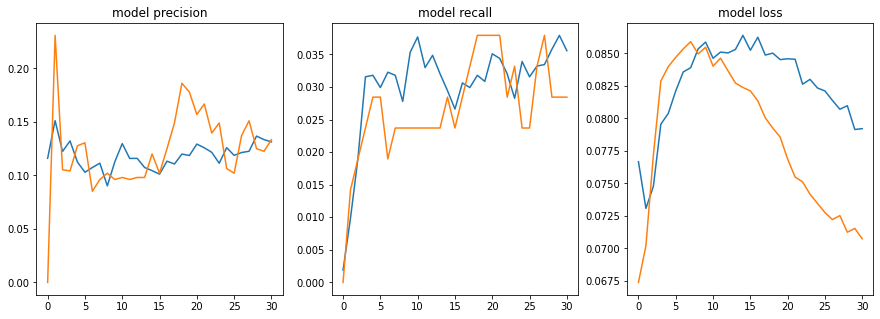

In [ ]:
plot_training(history)

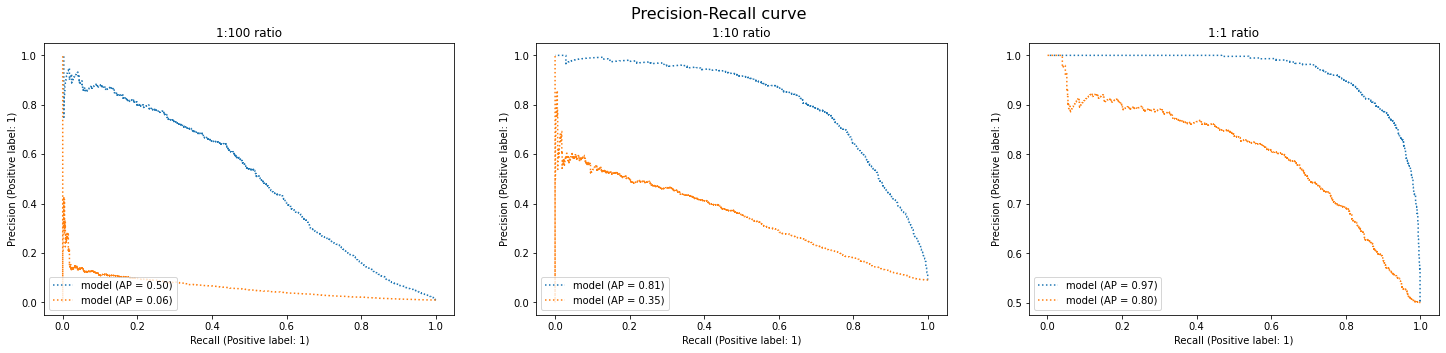

In [ ]:
test_and_plot([model_resnet_baseline, model_resnet], test_data_1, test_data_10, test_data_100, combine_method=None)